In [2]:
import numpy as np
from array import array
from os import stat
import matplotlib.pyplot as plt
import socket
import scipy.signal as signal

# Offline berechnung

In [3]:
 # read in I/Q samples from binary file
filename = r"C:\Users\yanni\OneDrive\Documents\Hochschule\5.Semester\PAIND\loraShortShort.sig"
n_float32 = int(stat(filename).st_size/4)
with open(filename,"rb") as binary_file:
    arr = array('f')
    arr.fromfile(binary_file,n_float32)
rx = np.array(arr.tolist()[::2])+1j*np.array(arr.tolist()[1::2])
rx /= np.amax(np.abs(rx)) # normalize to 1
rx -= np.mean(rx)    # remove DC
print("signal size:",rx.shape[0])

signal size: 11090432


In [4]:
print(rx.shape[0])

11090432


In [5]:
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

def analysis_DFTFB(x,w,fftlen,ts):
    # analysis FB
    # x      : input signal
    # w      : window
    # fftlen : FFT size, not exceeding the window length
    # ts     : downsampling factor, not exceeding the window length

    x_shape = x.shape
    y = np.reshape(x,(int(np.prod(x_shape[0:-1])),x_shape[-1]))
    n_symbols = int(np.ceil(x_shape[-1]/ts))
    z = np.zeros((int(np.prod(x_shape[0:-1])),n_symbols,fftlen),dtype=np.complex64)
    for i in range(y.shape[0]):
        yi = np.concatenate((y[i,:],np.zeros((ts-(x_shape[-1]%ts))%ts)))
        yi = yi.reshape((n_symbols,ts))
        wi = np.zeros((n_symbols,len(w)),dtype=np.complex64)
        for j in range(0,int(np.ceil(len(w)/ts))):
            i1 = np.minimum((j+1)*ts,len(w))
            wi[0:n_symbols-j,j*ts:i1] = np.tile(w[j*ts:i1],(n_symbols-j,1))*yi[j:,0:i1-j*ts]
        for j in range(1,int(np.ceil(len(w)/fftlen))):
            i1 = np.minimum((j+1)*fftlen,len(w))
            wi[:,0:i1-j*fftlen] = wi[:,0:i1-j*fftlen]+wi[:,j*fftlen:i1]
        z[i,:,:] = np.fft.fft(wi[:,0:fftlen])
    return z.reshape((x_shape[0:-1]+(n_symbols,fftlen)))

def display_spectrogram(x):
    fftlen = 512
    ts = 64
    w = np.sqrt(1/1536)*(1+np.cos(np.arange(-np.pi,np.pi,2*np.pi/fftlen)))/2

    z = 20*np.log10(np.abs(np.fft.fftshift(analysis_DFTFB(x,w,fftlen,ts),axes=1)))+1000
#       [Bug]: Colorbar does not work for negative values with contour/contourf #21882
    # display spectrum
    levels = MaxNLocator(nbins=15).tick_values(z.min(),z.max())
    cmap = plt.get_cmap('PiYG')
    norm = BoundaryNorm(levels,ncolors=cmap.N,clip=True)
    yp,xp = np.mgrid[slice(0,z.shape[0]),slice(0,z.shape[1])]
    fig = plt.figure()
    im = fig.gca().pcolormesh(xp,yp,z,cmap=cmap,norm=norm)
    fig.colorbar(im,ax=fig.gca())
    fig.gca().set_title('spectrogram')
    plt.show()

def display_spectrogram_if_signal(x,signal_strength):
    fftlen = 1024
    ts = 8
    w = np.sqrt(1/1536)*(1+np.cos(np.arange(-np.pi,np.pi,2*np.pi/fftlen)))/2

    z = 20*np.log10(np.abs(np.fft.fftshift(analysis_DFTFB(x,w,fftlen,ts),axes=1)))+1000
#       [Bug]: Colorbar does not work for negative values with contour/contourf #21882
    if(z.max() >= signal_strength):
        # display spectrum
        levels = MaxNLocator(nbins=15).tick_values(z.min(),z.max())
        cmap = plt.get_cmap('PiYG')
        norm = BoundaryNorm(levels,ncolors=cmap.N,clip=True)
        xp,yp = np.mgrid[slice(0,z.shape[0]),slice(0,z.shape[1])]               # yp,xp = np.mgrid[slice(0,z.shape[0]),slice(0,z.shape[1])]
        fig = plt.figure()
        im = fig.gca().pcolormesh(xp,yp,z,cmap=cmap,norm=norm)
        fig.colorbar(im,ax=fig.gca())
        fig.gca().set_title('spectrogram')
        plt.show()

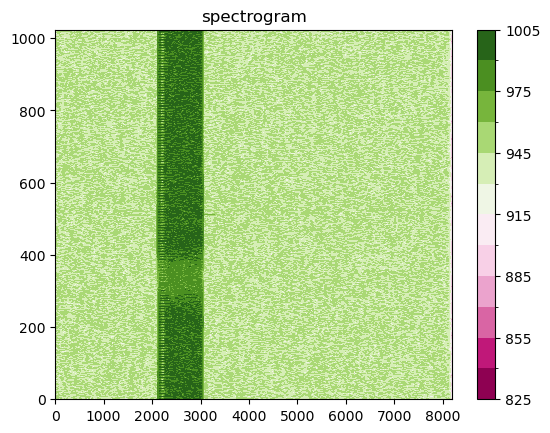

In [8]:
# Downsampling -> Überlagerung aller möglicher Frequenzbänder
# rxd = signal.decimate(rx,12)
#rxd = signal.resample(rx,round(len(rx)/12),domain="freq")
# rxd = rx[::11]
rxd = rx
while (len(rxd)>(2**16)):
    display_spectrogram_if_signal(rxd[:(2**16)],1000)
    rxd = rxd[(2**16):]



c:\Users\yanni\anaconda3\envs\PAIND\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


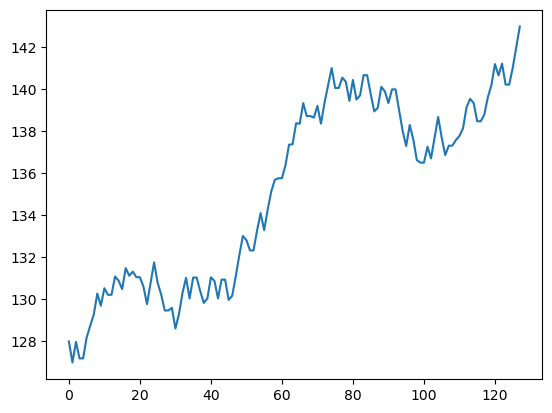

In [11]:
# Generiert alle möglichen Symbole

SF = 7                      # Spreading Factor
B = 125_000                 # Bandbreite
A = B                       # Abtastrate

N = 2**SF                   # Anzahl Bits/Symbol
Ts = N/B                    # Übertragungszeit eines Symbols
S = np.arange(0, N-1)       # LoRa Symbol = {0,...,127}

n = np.arange(Ts*B)        # Anzahl Abtastungen für ein Symbol

# Preambel (8x)
Pre = np.arange(len(n),dtype=np.complex64)   # Kompexe Signale => Vergleich mit dem Signal

k=0
for x in range(len(n)):
    Pre[x] = np.exp(2*np.pi*1j*((x**2)/(2*N)+((S[0]/N)-(1/2)))*x) - k*B
    if(Pre[x] >= B):
        k = k + 1

plt.plot(n,Pre)


In [7]:
import numpy as np

# Two versions of the chirp function are provided.  Depending on need
# it is more convenient sometimes to describe a chirp in terms of low
# and high frequencies, along with time length of chirp.  Other times
# it is convenient to describe chirp in terms of number of center frequency,
# bandwidth, repetition rate, and sample rate.
#
# The frequency based version generates the chirp waveform.  The center
# frequency described version simply has its parameters used to generate
# new parameters to call the first version.
#
# See http://en.wikipedia.org/wiki/Chirp for details on derivation.
#
# Mike Markowski, mike.ab3ap@gmail.com
# Mar 4, 2015


# chirp
#
# Generate a frequency sweep from low to high over time.
# Waveform description is based on number of samples.
#
# Inputs
#  fs_Hz: float, sample rate of chirp signal.
#  rep_Hz: float, repetitions per second of chirp.
#  f0_Hz: float, start (lower) frequency in Hz of chirp.
#  f1_Hz: float, stop (upper) frequency in Hz of chirp.
#  phase_rad: float, phase in radians at waveform start, default is 0.
#
# Output
#  Time domain chirp waveform of length numnSamples.

def chirp(fs_Hz, rep_Hz, f0_Hz, f1_Hz, periods=1, phase_rad=0):

    T_s = 1 / rep_Hz # Period of chirp in seconds.
    c = (f1_Hz - f0_Hz) / T_s # Chirp rate in Hz/s.
    n = int(fs_Hz / rep_Hz) # Samples per repetition.
    t_s = np.linspace(0, T_s, n) # Chirp sample times.

    # Phase, phi_Hz, is integral of frequency, f(t) = ct + f0.
    phi_Hz = (c * t_s**2) / 2 + (f0_Hz * t_s) # Instantaneous phase.
    phi_rad = 2 * np.pi * phi_Hz # Convert to radians.
    phi_rad += phase_rad # Offset by user-specified initial phase.
    return np.tile(np.exp(1j * phi_rad), periods) # Complex I/Q.

# chirpCtr
#
# Convenience function to create a chirp based on center frequency and
# bandwidth.  It simply calculates start and stop freuqncies of chirp and
# calls the chirp creation function.
#
# Inputs
#  fs_Hz: sample rate in Hz of chirp waveform.
#  fc_Hz: float, center frequency in Hz of the chirp.
#  rep_Hz: integer, number of full chirps per second.
#  bw_Hz: float, bandwidth of chirp.
#  phase_rad: phase in radians at waveform start, default is 0.
#
# Output
#  Time domain chirp waveform.

def chirpCtr(fs_Hz, fc_Hz, rep_Hz, bw_Hz, phase_rad=0):
    f0_Hz = fc_Hz - bw_Hz / 2.
    f1_Hz = fc_Hz + bw_Hz / 2.
    return chirp(fs_Hz, rep_Hz, f0_Hz, f1_Hz, phase_rad)

ValueError: Invalid number of FFT data points (0) specified.

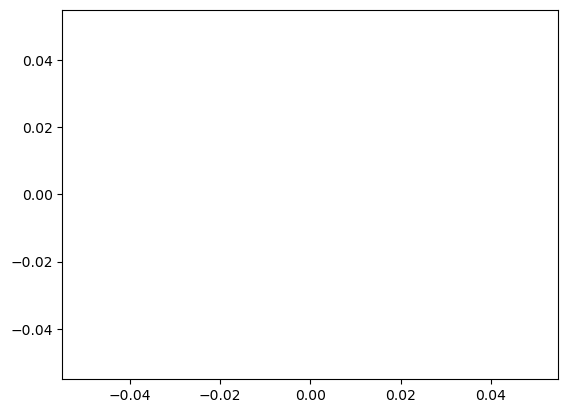

In [10]:
SF = 7                      # Spreading Factor
N = 2**SF                   # Bits/Symbol
B = 125_000                 # Bandbreite

fs = 2*B                    # Samplerate
fc = 0                      # Centerfrequency
rep = B/N              # Übertragungszeit eines Symbols
bw = B

chirp_t = chirpCtr(fs,fc,rep,bw)
plt.plot(np.arange(0,len(chirp_t)),chirp_t)

chirp_f = np.fft.fft(chirp_t,len(chirp_t))
plt.plot(len(chirp_f),chirp_f)



In [1]:
SF = 7                      # Spreading Factor
N = 2**SF                   # Bits/Symbol
B = 125_000                 # Bandbreite
fs = B                      # Abtastfrequenz

Ts = N/B                    # Übertragungszeit eines Symbols  (1.024ms)
S = np.arange(0, N-1)       # LoRa Symbol = {0,...,127}
n = np.arange(Ts*B)         # Anzahl Abtastungen für ein Symbol
nx = len(n)

Preamble_t = np.zeros(nx,dtype=np.complex64)

i = 0
for x in range(round(nx/2),nx):
    Preamble_t[i] = np.exp(2*np.pi*1j*((x**2)/(2*N)+((S[0]/N)-(1/2)))*x)
    i = i + 1

for x in range(0,round(nx/2)):
    Preamble_t[i] = np.exp(2*np.pi*1j*((x**2)/(2*N)+((S[0]/N)-(1/2)))*x)
    i = i + 1

display_spectrogram(Preamble_t)

#Preamble_f = np.fft.fft(Preamble_t)
#plt.plot(n,Preamble_f)



NameError: name 'np' is not defined

In [6]:
SF = 7                      # Spreading Factor
N = 2**SF                   # Bits/Symbol
B = 125_000                 # Bandbreite
fs = B                      # Abtastfrequenz
fb = 868_000_000

Ts = N/B                    # Übertragungszeit eines Symbols  (1.024ms)
S = np.arange(0, N-1)       # LoRa Symbol = {0,...,127}
n = np.arange(Ts*B)         # Anzahl Abtastungen für ein Symbol
nx = len(n)

Preamble_t = np.zeros(nx,dtype=np.complex64)

for x in range(0,nx):
    Preamble_t[x] = np.exp(2*np.pi*1j*((x**2)/(2*N)+((S[0]/N)-(1/2)))*x)

display_spectrogram(Preamble_t)

#Preamble_f = np.fft.fft(Preamble_t)
#plt.plot(n,Preamble_f)


ValueError: negative dimensions are not allowed